## Imports

In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

## Task 1:

Your current goal is get familiar with the data you were given, so in this task you should create a notebook that would show all data you have

In [15]:
item_categories = pd.read_csv("data/item_categories.csv")
items = pd.read_csv("data/items.csv")
sales_train = pd.read_csv("data/sales_train.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")
shops = pd.read_csv("data/shops.csv")
test = pd.read_csv("data/test.csv")

items = items.merge(item_categories, how="left", on="item_category_id", validate="m:1")
sales_train = sales_train.merge(shops, how="left", on="shop_id", validate="m:1")
sales_train = sales_train.merge(items, how="left", on="item_id", validate="m:m")
sales_train.to_csv("data/full_train.csv")
sales_train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,shop_name,item_name,item_category_id,item_category_name
0,02.01.2013,0,59,22154,999.00,1.0,"Ярославль ТЦ ""Альтаир""",ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray
1,03.01.2013,0,25,2552,899.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
2,05.01.2013,0,25,2552,899.00,-1.0,"Москва ТРК ""Атриум""",DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил
3,06.01.2013,0,25,2554,1709.05,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил
4,15.01.2013,0,25,2555,1099.00,1.0,"Москва ТРК ""Атриум""",DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства
...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0,"Москва ТРК ""Атриум""",V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства
2935845,09.10.2015,33,25,7460,299.00,1.0,"Москва ТРК ""Атриум""",V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства
2935846,14.10.2015,33,25,7459,349.00,1.0,"Москва ТРК ""Атриум""",V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства
2935847,22.10.2015,33,25,7440,299.00,1.0,"Москва ТРК ""Атриум""",V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3


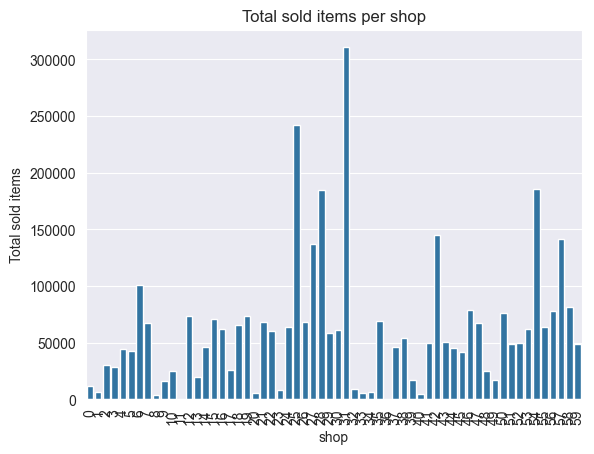

In [16]:
shop_sales = sales_train.groupby("shop_id")["item_cnt_day"].sum().reset_index()
sns.barplot(shop_sales, x="shop_id", y="item_cnt_day")
plt.title("Total sold items per shop")
plt.xlabel("shop")
plt.ylabel("Total sold items")
plt.xticks(rotation=90)
plt.show()

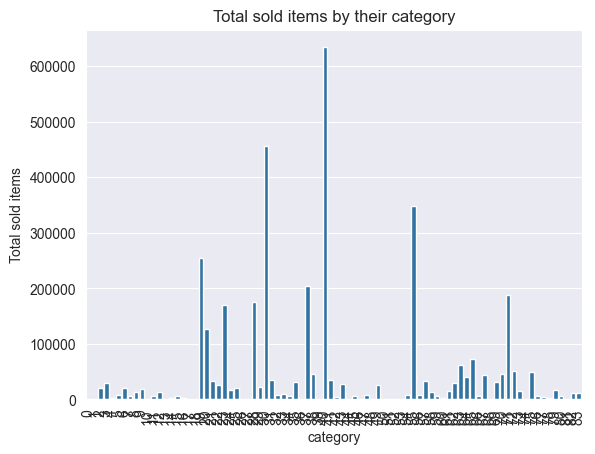

In [17]:
category_sales = sales_train.groupby("item_category_id")["item_cnt_day"].sum().reset_index()
sns.barplot(category_sales, x="item_category_id", y="item_cnt_day")
plt.title("Total sold items by their category")
plt.xlabel("category")
plt.ylabel("Total sold items")
plt.xticks(rotation=90)
plt.show()

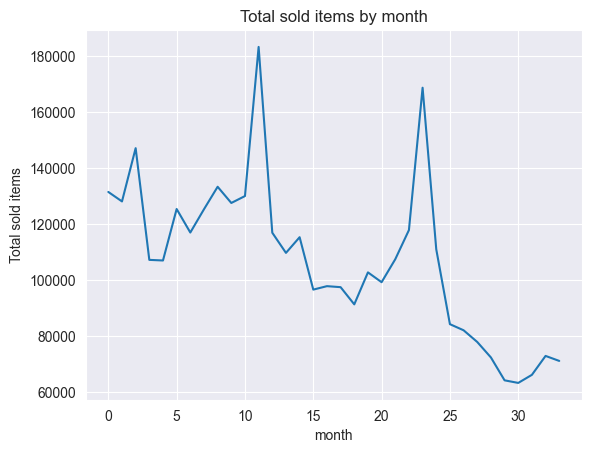

In [18]:
month_sales = sales_train.groupby("date_block_num")["item_cnt_day"].sum().reset_index()

sns.lineplot(month_sales, x="date_block_num", y="item_cnt_day")
plt.title("Total sold items by month")
plt.xlabel("month")
plt.ylabel("Total sold items")
plt.show()

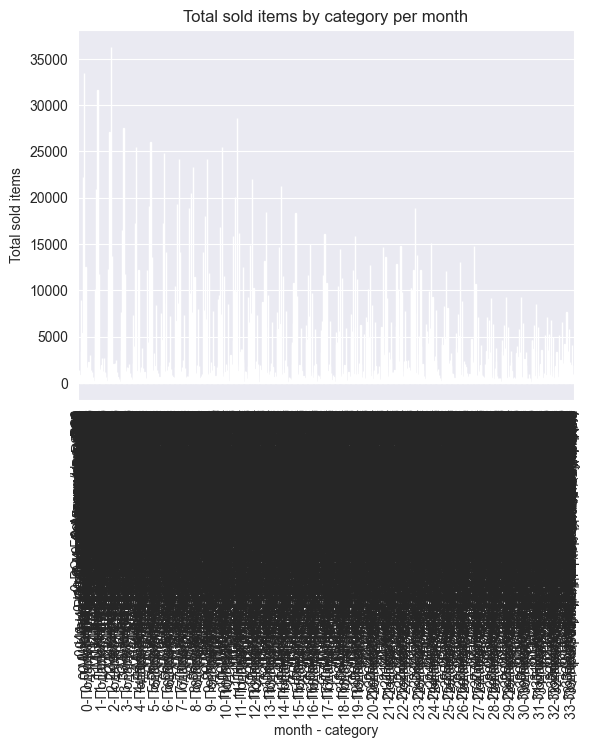

In [19]:
month_categories_sales: pd.DataFrame = sales_train.groupby(["date_block_num", "item_category_name"])["item_cnt_day"].sum().reset_index()

month_categories_sales["month_category"] = month_categories_sales["date_block_num"].astype(str) + "-" + month_categories_sales["item_category_name"]

sns.barplot(month_categories_sales, x="month_category", y="item_cnt_day", color="white")
plt.title("Total sold items by category per month")
plt.xlabel("month - category")
plt.ylabel("Total sold items")
plt.xticks(rotation=90)
plt.show()

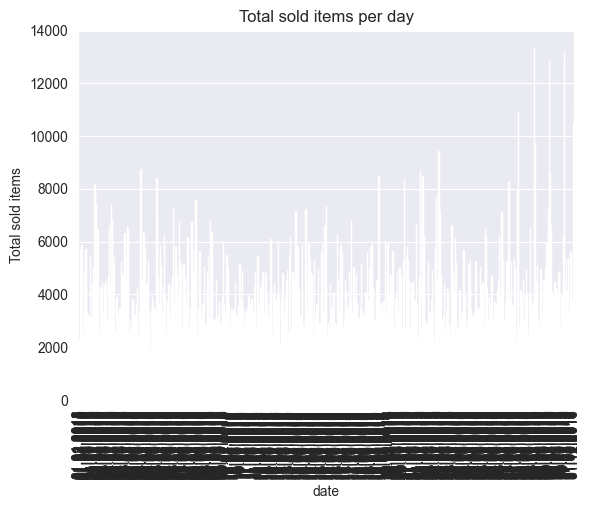

In [20]:
sales_per_day = sales_train.groupby("date")["item_cnt_day"].sum().reset_index()
sns.barplot(sales_per_day, x="date", y="item_cnt_day")
plt.title("Total sold items per day")
plt.xlabel("date")
plt.ylabel("Total sold items")
plt.xticks(rotation=90)
plt.show()

## Task 2
The second task is Data Quality Check layer. Since you would work a lot with your data, it would be useful to create a dqc notebook that would be used to mark all possible issues that your data have:
* Outliers
* Poor dynamic all a lot of missing information
* Data inconsistency

In [21]:
import pandas as pd
import numpy as np

class DQC:
    def __init__(self):
        self.processors = [
            DQC.mark_missing_values,
            DQC.mark_incorrect_item_cnt_day,
            DQC.mark_outliers
        ]

    def process(self, row_data: pd.DataFrame) -> pd.DataFrame:
        df: pd.DataFrame = row_data.copy()
        df = df.drop_duplicates()

        for processor in self.processors:
            df = processor(df)

        return df

    @staticmethod
    def mark_missing_values(row_data: pd.DataFrame) -> pd.DataFrame:
        missing_count = row_data.isna().sum(axis=1)
        row_data["missing_values_count"] = missing_count
        return row_data

    @staticmethod
    def mark_outliers(row_data: pd.DataFrame) -> pd.DataFrame:
        columns = row_data.select_dtypes(include=np.number).columns.tolist()

        outlier_mask = pd.Series([False] * len(row_data), index=row_data.index)

        for column in columns:
            Q1 = row_data[column].quantile(0.25)
            Q3 = row_data[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            column_outlier_mask = (row_data[column] < lower_bound) | (row_data[column] > upper_bound)

            outlier_mask = outlier_mask | column_outlier_mask

        row_data["is_outlier"] = outlier_mask
        return row_data

    @staticmethod
    def mark_incorrect_item_cnt_day(row_data: pd.DataFrame) -> pd.DataFrame:
        mask = row_data["item_cnt_day"] < 0
        row_data["incorrect_item_cnt_day"] = mask
        return row_data

## ETL classes (Task 4)

### Extractor:

Extract row data from a source, also check for file existing and file extension.

In [22]:
class Extractor:
    def __init__(self, source: str):
        self.source = source

    def __call__(self) -> pd.DataFrame:
        assert os.path.exists(self.source), Exception(f"There is no file named '{self.source}'.")
        assert os.path.splitext(self.source)[1] == ".csv", Exception(f"Unsupported file extension '{self.source}'.")

        row_data = pd.read_csv(self.source)
        return row_data

### Transformer:

Transformer specification is to transform data into valid state. It includes:

- Normalization,
- Standardization,
- Empty values handling,
- Dropping outliers,
- etc.


In [23]:
class Transformer:
    def __init__(
            self,
            normalization_columns: list = None,
            standardization_columns: list = None,
            one_hot_columns: list = None,
            dropped_columns: list = None,
        ):
        self.normalization_columns = normalization_columns if normalization_columns else []
        self.standardization_columns = standardization_columns if standardization_columns else []
        self.one_hot_columns = one_hot_columns if one_hot_columns else []
        self.dropped_columns = dropped_columns if dropped_columns else []

        self.normalizers = {col: MinMaxScaler() for col in self.normalization_columns}
        self.standardizers = {col: StandardScaler() for col in self.standardization_columns}

        self.processors = [
            self.drop_missing_values,
            self.drop_outliers,
            self.drop_incorrect_item_cnt_day,
            self.normalize,
            self.standardize,
            self.one_hot_encoding,
            self.drop_columns,
        ]

    def __call__(self, row_data: pd.DataFrame) -> pd.DataFrame:
        assert row_data.shape[0] > 0, Exception("There is no row data with size > 0.")

        dqc = DQC()
        df: pd.DataFrame = dqc.process(row_data.copy())
        for processor in self.processors:
            df = processor(df)

        return df

    def drop_missing_values(self, row_data: pd.DataFrame) -> pd.DataFrame:
        return row_data.drop(row_data[row_data["missing_values_count"] != 0].index)

    def drop_outliers(self, row_data: pd.DataFrame) -> pd.DataFrame:
        return row_data[~row_data["is_outlier"]]

    def drop_columns(self, row_data: pd.DataFrame) -> pd.DataFrame:
        return row_data.drop(self.dropped_columns, axis=1)

    def drop_incorrect_item_cnt_day(self, row_data: pd.DataFrame) -> pd.DataFrame:
        return row_data[~row_data["incorrect_item_cnt_day"]]

    def normalize(self, row_data: pd.DataFrame) -> pd.DataFrame:
        for column, normalizer in self.normalizers.items():
            if not np.issubdtype(row_data[column].dtype, np.number):
                raise Exception(f"Normalization column '{column}' is not a number.")

            row_data[column] = normalizer.fit_transform(row_data[[column]])

        return row_data

    def standardize(self, row_data: pd.DataFrame) -> pd.DataFrame:
        for column, standardizer in self.standardizers.items():
            if not np.issubdtype(row_data[column].dtype, np.number):
                raise Exception(f"Standardization column '{column}' is not a number.")

            row_data[column] = standardizer.fit_transform(row_data[[column]])

        return row_data

    def one_hot_encoding(self, row_data: pd.DataFrame) -> pd.DataFrame:
        row_data = pd.get_dummies(row_data, columns=self.one_hot_columns, drop_first=True)
        return row_data

### Loader:

Load data into goal system (database, model, reports, etc.)


In [24]:
class Loader:
    def __init__(self, source: str):
        self.source = source

    def __call__(self, row_data: pd.DataFrame) -> None:
        row_data.to_csv(self.source, index=False)
        print(row_data)

In [25]:
class ETL:
    def __init__(self, import_path: str, export_path: str):
        self.import_path = import_path
        self.export_path = export_path

        self.extractor = Extractor(source=self.import_path)
        self.transformer = Transformer(
            normalization_columns=["item_price"],
            dropped_columns=[
                "is_outlier",
                "incorrect_item_cnt_day",
                "missing_values_count"
            ],
        )
        self.loader = Loader(source=self.export_path)

    def __call__(self):
        row_data = self.extractor()
        row_data = self.transformer(row_data)
        self.loader(row_data)

In [26]:
etl = ETL("data/full_train.csv", "data/sales_post_process.csv")
etl()

         Unnamed: 0        date  date_block_num  shop_id  item_id  item_price  \
0                 0  02.01.2013               0       59    22154    0.470588   
1                 1  03.01.2013               0       25     2552    0.423529   
3                 3  06.01.2013               0       25     2554    0.804729   
4                 4  15.01.2013               0       25     2555    0.517647   
5                 5  10.01.2013               0       25     2564    0.164706   
...             ...         ...             ...      ...      ...         ...   
2935844     2935844  10.10.2015              33       25     7409    0.141176   
2935845     2935845  09.10.2015              33       25     7460    0.141176   
2935846     2935846  14.10.2015              33       25     7459    0.164706   
2935847     2935847  22.10.2015              33       25     7440    0.141176   
2935848     2935848  03.10.2015              33       25     7460    0.141176   

         item_cnt_day      